# Finding the Port Address

To figure out the serial port address, the following code will print out all available ports.  

It is usually pretty obvious which port is associated with the MCO.  This port address needs to be copied to the `port` variable in the following cell.

In [5]:
import serial.tools.list_ports
#Find USB Port
def find_port():  #Finds which port are connected 
    ports = list(serial.tools.list_ports.comports())
    for p in ports:
        print(p)
find_port()

/dev/cu.Bluetooth-Incoming-Port - n/a


# Code for collecting data from Teensy Board

The following code is from Eric Ayars.  It has the ability to control the teensy, collect data, and print data.  Take a look at the comments to see how to do each of these things.

 - Collect Data:
Type `c 10 filename.txt` to take 10 cycles of data and save it to the file named `filename.txt`

*Note:* 10 cycles should be sufficient for many situations.  I was collecting data for 100 to 1000, which ends up being a loooong time.  The board is locked up and can't be controlled with Python.  However, you can open the Arduino IDE and type `rept 0` to shut off reporting and then restart the Python kernel in this notebook if you accidentally give it a long data collection time.

- Plot Data:
Type 'p 10 filename.txt' to plot theta vs. theta_dot.  

The data needs to already be saved.  What I don't understand is the code uses $2 \pi/1016$ to convert from raw data to radians.  However, it looks to me like the data goes from -2048 to +2048 for a complete revolution so the conversion should be $pi/2048$.  

To Do:
- Try to figure out why EA uses 1016



In [ ]:
from pylab import *
import serial


port = '/dev/cu.usbmodem58794001'

ser = serial.Serial(port, 115200, timeout=1) 



def writeln(S):
    # encodes a string as bytearray and writes it on serial
    S = S + '\n'
    ser.write(S.encode())

def readln(ser):
    # reads a bytearray from serial and converts it to a string
    BA = ser.readline().decode("utf-8")
    return BA

def getData(N, file):
	# gets N periods worth of data, saves raw data lines to a file.

	N = 256*N
	print("Saving %d data points to file '%s'." % (N, file))

	# get useful data from the MCO
	writeln('freq?')
	freq = float(readln(ser))
	writeln('ampl?')
	ampl = int(readln(ser))

	# open the file and write the header
	fh = open(file, 'w')
	fh.write("# Frequency = %0.2f\n# Amplitude = %d\n" %(freq, ampl))

	# Activate data reporting
	writeln('rept 1')

	# drop lines until the end of a drive cycle.
	line = readln(ser)
	while int(line.split()[0]) != 255:
		line = readln(ser)

	# collect N data lines
	for j in range(N):
		fh.write(readln(ser))
	writeln('rept 0')

	# clean up
	fh.close()

def showPlot(file, save=False, polar=False):

	# get the data
	phase, angle, velocity = loadtxt(file, unpack=True)

	# plot the phase space graph, cartesian
	if not polar:
		ax = subplot(111)
		ax.plot(angle*2.*pi/1016., velocity*2.*pi/1016., 'b,')
		xlabel('Angle (radians)')
		ylabel('Angular Velocity (radians/second)')
		xlim(-pi, pi)

	# plot the phase space graph, polar
	else:
		ax = subplot(111, projection='polar')
		ax.plot(angle*2.*pi/1016., velocity*2.*pi/1016., 'b,')
		ax.set_rmax(max(ceil(abs(velocity))))
		ax.grid(True)

	title(file)

	# save the plot
	if save:
		savefig(file+'.pdf')

	# show the plot
	show()



# startup test
writeln('*idn?')
print(readln(ser))

command = ''


# Main loop
while command != 'quit':
	command = input('-> ')

	# parse command
	
	# go through some special cases here

	if command == 'quit':
		continue
	
	if command == '':
		print(readln(ser))
		continue

	com = command.split()
	if com[0] == 'c':
		# c for collect. Follow 'c' with N and filename.
		# Note: no error-checking! Do it right or suffer. :-(
		N = int(com[1])
		filename = com[2]
		getData(N, filename)
		continue
	if (com[0] == 'p') or (com[0] == 'l'):
		save_figure = False
		if filename:
			try:
				if com[1] == 's':
					save_figure = True
			except:
				pass
			if com[0] == 'l':
				showPlot(filename, save=save_figure, polar=True)
			else:
				showPlot(filename, save=save_figure, polar=False)
		else:
			print('No filename given.')
		continue

	# No special case, just write and read.
	writeln(command)
	print(readln(ser))

ser.close()


# Simple Damping Data

I hooked up the external coils and set the voltage to 4.0 V (random value that keeps current below an amp) and moved the magnet close to the disk (forgot to record the value - oops)

Data saved to `more_data.txt` in this directory

# Loading Data from File

I'll try `np.loadtxt` to load data.

Note: This is _not_ comma separated.  The delimiter is a space so `delimiter = ' '` (with a space between the single quotes) is needed here.

I'm not sure how to deal with the `nan`'s that show up when the velocity is zero.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


#Replace 'more_data.txt' with whatever file name you used for your saved data
data = np.loadtxt(fname='more_data.txt', delimiter=' ')

print(data)

[[0.00000000e+00 1.13600000e+03 5.34079346e+03]
 [1.00000000e+00 1.15700000e+03 5.32724512e+03]
 [2.00000000e+00 1.17800000e+03 5.31773438e+03]
 ...
 [2.53000000e+02 9.74000000e+02 4.18322540e+02]
 [2.54000000e+02 9.75000000e+02 4.16493134e+02]
 [2.55000000e+02 9.77000000e+02 4.31778931e+02]]


It looks like it worked.  Now I need to break the array up into three separate column arrays. 

Actually, I don't think I need the first column.  It isn't clear to me why the first column cycles from 0 to 255.  

To Do:
- Take a look at the Arduino code for the teensy to see if I can figure out where this is coming from


I'm including `N_starting_data` and `N_ending_data` so I can easily just look at data points between those two values.

Total data points in this file: 2560
-2047.0
2043.0


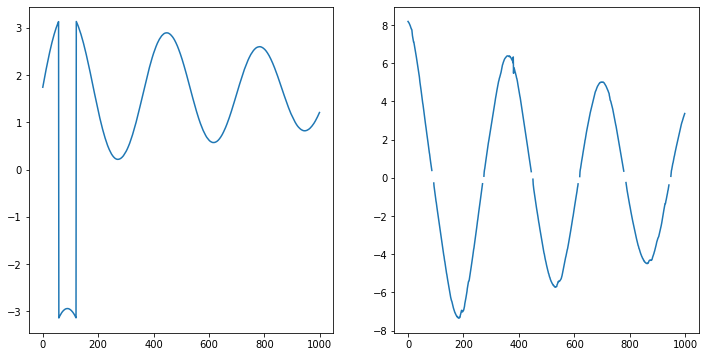

In [8]:

print("Total data points in this file:", len(data[:,0]))

# Specifies which data points to start and stop with
N_starting_data = 0
N_ending_data = 1000

raw_theta = data[N_starting_data:N_ending_data,1]
raw_angular_velocity = data[N_starting_data:N_ending_data,2]
# First column isn't useful so we need to create a new column 
time_step_number = np.arange(0,len(raw_theta))

# What are the two extremes of values
print(np.min(raw_theta))
print(np.max(raw_theta))

raw_theta_max = 2048

#Convert raw data to angular data
theta = raw_theta*np.pi/raw_theta_max

#Not sure if this is radians per second
angular_velocity = raw_angular_velocity*np.pi/raw_theta_max

# Plot data
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(12,6))

ax1.plot(time_step_number, theta)
ax2.plot(time_step_number, angular_velocity)
plt.show()

Looking good!!  There is hope :)

The gaps in the second graph are due to the nan values.

To Do:
- Fix nan values

I don't know what is up with the dip in the left graph near the beginning.  It almost looks like the data got too large and wrapped around to negative numbers.  This doesn't make sense.

Let's take a look at the phase portrait (below).  You can clearly see it spiraling in, which is what you expect with the external coils on and damping.

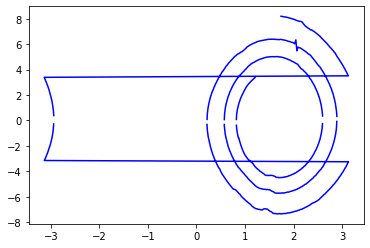

In [10]:
plt.plot(theta, angular_velocity, 'b')
plt.show()

# Dealing with nan's

I've got a data file with mostly nans for the third column (`fname = test_data.txt`)

I'm going to try using `genfromtxt()` which can replace missing values.  I also need to figure out what these `nan`'s are.  Are they strings or something else?

So these are numpy `nan`'s, which means I can use `np.isnan()` to test for those values.

`genfromtxt` didn't do anything beyond what `loadtxt` did (i.e. it doesn't replace the `nan`'s with zeros) 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


data_nan = np.loadtxt(fname='test_data.txt', delimiter=' ')


data = np.genfromtxt("more_data.txt", delimiter=" ", skip_header=3, missing_values=0,filling_values=0)
print(data_nan)
print(data_nan[-1,2],type(data_nan[-1,2]))

[[  0.          -1.                  nan]
 [  1.          -1.                  nan]
 [  2.           0.          62.34025192]
 ...
 [253.          -2.                  nan]
 [254.          -2.                  nan]
 [255.          -2.                  nan]]
nan <class 'numpy.float64'>


# Killing the nans

I'll use a `for` loop to go through the entire array (there is probably a more pythonic way or numpy way to do this) and then an `if` statement to replace nans with zero.


It sort of works but the graphs looks funny at the joint.  It may be worth either leaving the gaps in or interpolating at those points.


Total data points in this file: 2559
<class 'numpy.float64'>


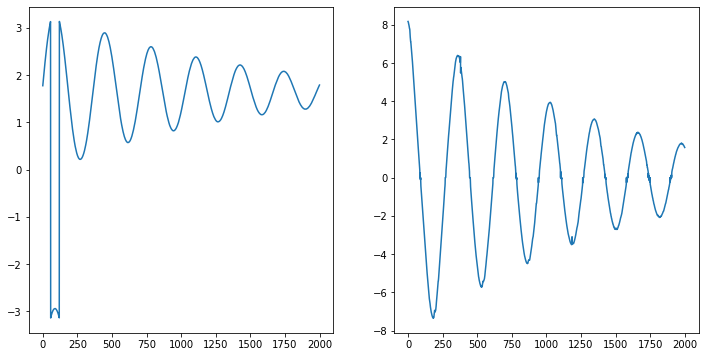

In [3]:
print("Total data points in this file:", len(data2[:,0]))

# Specifies which data points to start and stop with
N_starting_data = 0
N_ending_data = 2000

raw_theta = data2[N_starting_data:N_ending_data,1]
raw_angular_velocity = data2[N_starting_data:N_ending_data,2]
# First column isn't useful so we need to create a new column 
time_step_number = np.arange(0,len(raw_theta))

#Remove nans and replace with 0
for i in range(len(raw_angular_velocity)):
    if np.isnan(raw_angular_velocity[i]):
        raw_angular_velocity[i] = 0

print(type(raw_angular_velocity[227]))

raw_theta_max = 2048

#Convert raw data to angular data
theta = raw_theta*np.pi/raw_theta_max

#Not sure if this is radians per second
angular_velocity = raw_angular_velocity*np.pi/raw_theta_max

# Plot data
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(12,6))

ax1.plot(time_step_number, theta)
ax2.plot(time_step_number, angular_velocity)
plt.show()

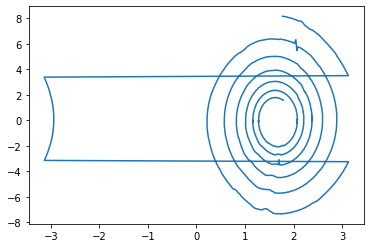

In [4]:
plt.plot(theta, angular_velocity)